<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/10_PyTorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch를 이용한 MNIST Data 분류(Classification)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F # DL에서 자주 사요되는 수학적 함수들
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
# %matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
is_cuda #--> True이면 GPU 사용 가능

True

In [3]:
device = torch.device('cuda' if is_cuda else "cpu")
print('Current device is', device)

Current cuda device is cuda


## - Data setting

In [4]:
# hyperparameter 설정

epochs = 15
batch_size = 50 #--> 몇 개의 데이터를 한번에 모아서 가중치를 업데이트하는 계산에 사용할 것인가
learning_rate = 0.0001

In [5]:
# MNIST Data 불러오기

# data 전처리 설정으로 바로 tensor로 변형
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

print('number of train data:', len(train_data))
print('number of test data:', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 105048325.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22141417.26it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31424728.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5427501.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of training data: 60000
number of test data: 10000


In [10]:
train_data[0][0].shape, train_data[0][1]
#--> [image data], label

(torch.Size([1, 28, 28]), 5)

In [12]:
# keras는 채널의 차원이 shape의 맨 마지막에 온다. [28, 28, 1]
# torch는 채널의 차원이 shape 첫번째에 존재한다. [1, 28, 28]
# squeeze()는 차원(dimension)이 1인 것을 없애는 함수이다.

train_data[0][0].squeeze().shape

torch.Size([28, 28])

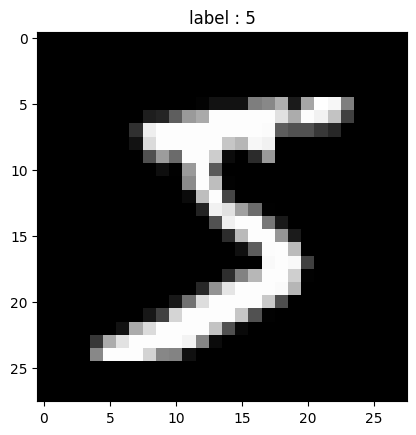

In [13]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [14]:
# mini batch 구성 설정

# shuffle의 의미는 데이터의 순서를 학습하지 못하게 하는 것이다.
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# 첫번째 묶음(batch)를 가져와 확인
first_batch = train_loader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape)) #--> pixel data
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape)) #--> label

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


## - class model

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # in_channels: int, out_channels: int, kernel_size: _size_2_t(3x3), stride: _size_2_t = 1
        # padding='same' --> convolutional filter에 의해 이미지 사이즈가 줄어드는 것을 방지, how? 테두리에 0을 채워서
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000) #--> 7 x 7 x 64 = 3136
        self.fc2 = nn.Linear(1000, 10) # in_features: int, out_features: int

    def forward(self, x): #--> 28 x 28
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #--> 14 x 14

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #--> 7 x 7

        x = self.dropout(x)
        x = torch.flatten(input=x, start_dim=1) #--> 7 x 7 x 64, 차원 변환만 시도
        x = self.fc1(x) #<-- 7 x 7 x 64
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(input=x, dim=1)

        return output

In [26]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [27]:
import time

model.train() #--> 모델 학습 선언 (실제 학습 X), model을 train 모드로 바꾼다.
i = 1
for epoch in range(epochs):
    start_time_each_epoch = time.time()
    
    for data, target in train_loader:
        # print(data.shape)
        #--> data에는 batch로 묶은 50개의 이미지 정보가 담긴다.
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward() #--> Weight 역전파
        optimizer.step() #--> Wehght Update

        if i % 1000 == 0:
            print(time.time() - start_time_each_epoch)
            print("Train Step: {}\tLoss: {:.3f}".format(i, loss.item()))
        i += 1

Train Step: 1000	Loss: 0.206
Train Step: 2000	Loss: 0.023
Train Step: 3000	Loss: 0.113
Train Step: 4000	Loss: 0.098
Train Step: 5000	Loss: 0.065
Train Step: 6000	Loss: 0.133
Train Step: 7000	Loss: 0.001
Train Step: 8000	Loss: 0.032
Train Step: 9000	Loss: 0.021
Train Step: 10000	Loss: 0.020
Train Step: 11000	Loss: 0.006
Train Step: 12000	Loss: 0.010
Train Step: 13000	Loss: 0.003
Train Step: 14000	Loss: 0.003
Train Step: 15000	Loss: 0.022
Train Step: 16000	Loss: 0.002
Train Step: 17000	Loss: 0.017
Train Step: 18000	Loss: 0.000


In [28]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set Accuracy : {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set Accuracy : 99.22%
